# EECS 498-008/598-008 Assignment 6-1: Variational AutoEncoders

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Hello WORLD, #XXXXXXXX


# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and a conditional variational autoencoder with slightly different architectures and apply them to the popular MNIST handwritten dataset. Recall from lecture (https://web.eecs.umich.edu/~justincj/slides/eecs498/FA2020/598_FA2020_lecture19.pdf), an autoencoder seeks to learn a latent representation of our training images by using unlabeled data and learning to reconstruct its inputs. The *variational autoencoder* extends this model by adding a probabilistic spin to the encoder and decoder, allowing us to sample from the learned distribution of the latent space to generate new images at inference time.

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.


In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['eecs598', 'gan.py', 'generative_adversarial_networks.ipynb', 'a6_helper.py', 'vae.py', 'variational_autoencoders.ipynb']
```

In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A6 folder, then '2020FA/A6'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_PATH = './'
print(os.listdir(GOOGLE_DRIVE_PATH))

['a6_helper.py', 'eecs598', 'gan.py', 'generative_adversarial_networks.ipynb', 'images', 'network_visualization.ipynb', 'network_visualization.py', 'style_transfer.ipynb', 'style_transfer.py', 'vae.py', 'variational_autoencoders.ipynb']


Once you have successfully mounted your Google Drive and located the path to 
this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from vae.py!
Hello from a6_helper.py!
```

as well as the last edit time for the file `vae.py`.

In [3]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
# os.environ["TZ"] = "US/Eastern"
# time.tzset()

from vae import hello_vae
hello_vae()

from a6_helper import hello_helper
hello_helper()

Hello from vae.py!
Hello from a6_helper.py!


Load several useful packages that are used in this notebook:

In [4]:
from eecs598.grad import rel_error
from eecs598.utils import reset_seed
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline


# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [5]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load MNIST Dataset


VAEs (and GANs as you'll see in the next notebook) are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which has 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

In [6]:
batch_size = 128

mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:43<00:00, 230kB/s] 


Extracting ./MNIST_data\MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]


Extracting ./MNIST_data\MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:04<00:00, 334kB/s]


Extracting ./MNIST_data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:01<00:00, 4.39kB/s]

Extracting ./MNIST_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST_data\MNIST\raw



## Visualize dataset

It is always a good idea to look at examples from the dataset before working with it. Let's visualize the digits in the MNIST dataset. We have defined the function `show_images` in `a6_helper.py` that we call to visualize the images.


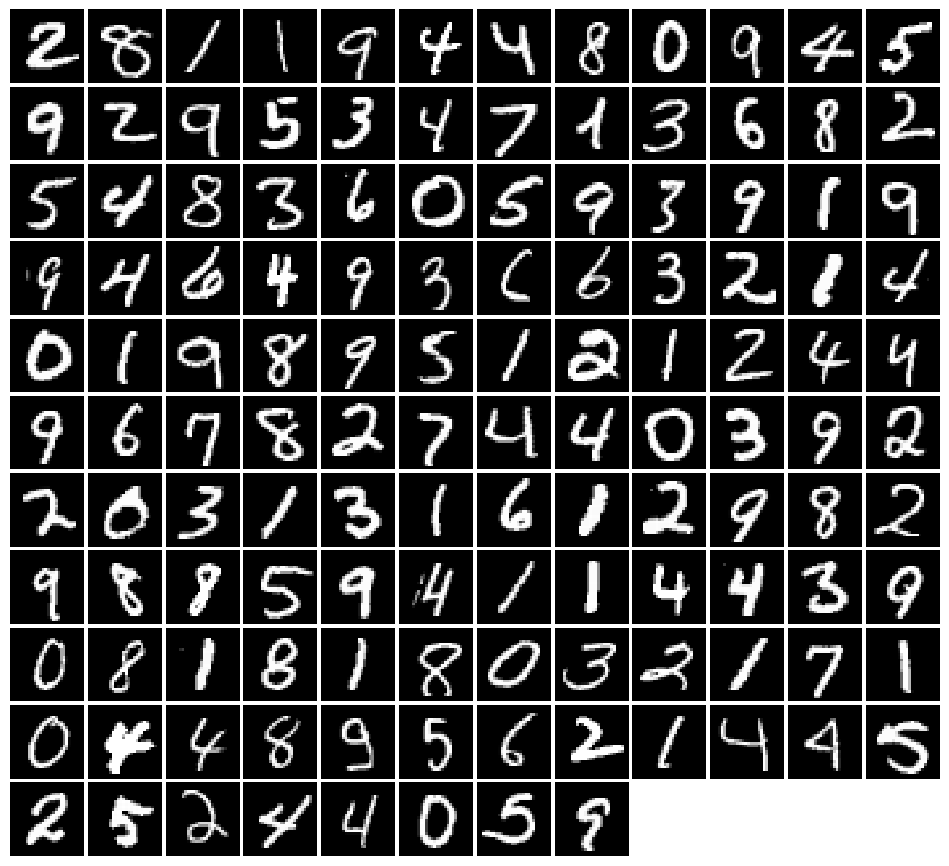

In [8]:
from a6_helper import show_images

imgs = next(loader_train.__iter__())[0].view(batch_size, 784)
show_images(imgs)

# Fully Connected VAE

Our first VAE implementation will consist solely of fully connected layers. We'll take the `1 x 28 x 28` shape of our input and flatten the features to create an input dimension size of 784. In this section you'll define the Encoder and Decoder models in the VAE class of `vae.py` and implement the reparametrization trick, forward pass, and loss function to train your first VAE.

## FC-VAE Encoder

Now lets start building our fully-connected VAE network. We'll start with the encoder, which will take our images as input (after flattening C,H,W to D shape) and pass them through a three Linear+ReLU layers. We'll use this hidden dimension representation to predict both the posterior mu and posterior log-variance using two separate linear layers (both shape (N,Z)). 

Note that we are calling this the 'logvar' layer because we'll use the log-variance (instead of variance or standard deviation) to stabilize training. This will specifically matter more when you compute reparametrization and the loss function later. 

*Define an `encoder`, `hidden_dim` (H), `mu_layer`, and `logvar_layer` in the initialization of the VAE class in `vae.py`. Use nn.Sequential to define the encoder, and separate Linear layers for the mu and logvar layers. In all of these layers, H will be a hidden dimension you set and will be the same across all encoder and decoder layers. Architecture for the encoder is described below:*


 * `Flatten` (Hint: nn.Flatten)
 * Fully connected layer with input size 784 (`input_size`) and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`


## FC-VAE Decoder

We'll now define the decoder, which will take the latent space representation and generate a reconstructed image. The architecture is as follows: 

 * Fully connected layer with input size as the latent size (Z) and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size 784 (`input_size`)
 * `Sigmoid`
 * `Unflatten` (nn.Unflatten)

*Define a `decoder` in the initialization of the VAE class in `vae.py`. Like the encoding step, use `nn.Sequential`*  



## Reparametrization 




Now we'll apply a reparametrization trick in order to estimate the posterior $z$ during our forward pass, given the $\mu$ and $\sigma^2$ estimated by the encoder. A simple way to do this could be to simply generate a normal distribution centered at our  $\mu$ and having a std corresponding to our $\sigma^2$. However, we would have to backpropogate through this random sampling that is not differentiable. Instead, we sample initial random data $\epsilon$ from a fixed distrubtion, and compute $z$ as a function of ($\epsilon$, $\sigma^2$, $\mu$). Specifically:

$z = \mu + \sigma\epsilon$

We can easily find the partial derivatives w.r.t $\mu$ and $\sigma^2$ and backpropagate through $z$. If $\epsilon = \mathcal{N} (0,1)$, then it's easy to verify that the result of our forward pass calculation will be a distribution centered at $\mu$ with variance $\sigma^2$.

Implement `reparametrization` in `vae.py` and verify your mean and std error are at or less than `1e-4`.

In [14]:
reset_seed(0)
from vae import reparametrize
latent_size = 15
size = (1, latent_size)
mu = torch.zeros(size)
logvar = torch.ones(size)

z = reparametrize(mu, logvar)

expected_mean = torch.FloatTensor([-0.4363])
expected_std = torch.FloatTensor([1.6860])
z_mean = torch.mean(z, dim=-1)
z_std = torch.std(z, dim=-1)
assert z.size() == size

print('Mean Error', rel_error(z_mean, expected_mean))
print('Std Error', rel_error(z_std, expected_std))
print(z_mean, expected_mean)

Mean Error 5.639056398351415e-05
Std Error 7.1412955526273885e-06
tensor([-0.4363]) tensor([-0.4363])


## FC-VAE Forward

Complete the VAE class by writing the forward pass. The forward pass should pass the input image through the encoder to calculate the estimation of mu and logvar, reparametrize to estimate the latent space z, and finally pass z into the decoder to generate an image.



## Loss Function

Before we're able to train our final model, we'll need to define our loss function. As seen below, the loss function for VAEs contains two terms: A reconstruction loss term (left) and KL divergence term (right). 

$-E_{Z~q_{\phi}(z|x)}[log p_{\theta}(x|z)] + D_{KL}(q_{\phi}(z|x), p(z)))$

Note that this is the negative of the variational lowerbound shown in lecture--this ensures that when we are minimizing this loss term, we're maximizing the variational lowerbound. The reconstruction loss term can be computed by simply using the binary cross entropy loss between the original input pixels and the output pixels of our decoder (Hint: `nn.functional.binary_cross_entropy`). The KL divergence term works to force the latent space distribution to be close to a prior distribution (we're using a standard normal gaussian as our prior).

To help you out, we've derived an unvectorized form of the KL divergence term for you.
Suppose that $q_\phi(z|x)$ is a $Z$-dimensional diagonal Gaussian with mean $\mu_{z|x}$ of shape $(Z,)$ and standard deviation $\sigma_{z|x}$ of shape $(Z,)$, and that $p(z)$ is a $Z$-dimensional Gaussian with zero mean and unit variance. Then we can write the KL divergence term as:

$D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{J} (1 + log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j}$)

It's up to you to implement a vectorized version of this loss that also operates on minibatches.
You should average the loss across samples in the minibatch.

Implement `loss_function` in `vae.py` and verify your implementation below. Your relative error should be less than or equal to `1e-5`



In [15]:
from vae import loss_function
size = (1,15)

image = torch.sigmoid(torch.FloatTensor([[2,5], [6,7]]).unsqueeze(0).unsqueeze(0))
image_hat = torch.sigmoid(torch.FloatTensor([[1,10], [9,3]]).unsqueeze(0).unsqueeze(0))

expected_out = torch.tensor(8.5079)
mu, logvar = torch.ones(size), torch.zeros(size)
out = loss_function(image, image_hat, mu, logvar)
print('Loss error', rel_error(expected_out,out))

Loss error 2.1297676389877955e-06



## Train a model

Now that we have our VAE defined and loss function ready, lets train our model! Our training script is provided  in `a6_helper.py`, and we have pre-defined an Adam optimizer, learning rate, and # of epochs for you to use. 

Training for 10 epochs should take ~2 minutes and your loss should be less than 120.

In [17]:
num_epochs = 10
latent_size = 15
from vae import VAE
from a6_helper import train_vae
input_size = 28*28
device = 'cuda'
vae_model = VAE(input_size, latent_size=latent_size)
vae_model.cuda()
for epoch in range(0, num_epochs):
    train_vae(epoch, vae_model, loader_train)

Train Epoch: 0 	Loss: 172.339142
Train Epoch: 1 	Loss: 151.813705
Train Epoch: 2 	Loss: 137.767120
Train Epoch: 3 	Loss: 132.177948
Train Epoch: 4 	Loss: 123.123283
Train Epoch: 5 	Loss: 128.469208
Train Epoch: 6 	Loss: 118.719009
Train Epoch: 7 	Loss: 122.571861
Train Epoch: 8 	Loss: 124.453018
Train Epoch: 9 	Loss: 124.114059


## Visualize results

After training our VAE network, we're able to take advantage of its power to generate new training examples. This process simply involves the decoder: we intialize some random distribution for our latent spaces z, and generate new examples by passing these latent space into the decoder. 

Run the cell below to generate new images! You should be able to visually recognize many of the digits, although some may be a bit blurry or badly formed. Our next model will see improvement in these results. 

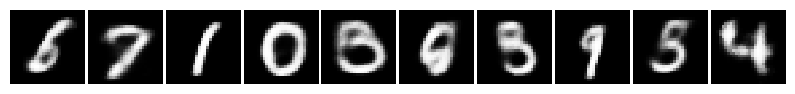

In [20]:
z = torch.randn(10, latent_size).to(device='cuda')
import matplotlib.gridspec as gridspec
vae_model.eval()
samples = vae_model.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(10, 1))
gspec = gridspec.GridSpec(1, 10)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28), cmap='Greys_r')
    plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'vae_generation.jpg'))

## Latent Space Interpolation

As a final visual test of our trained VAE model, we can perform interpolation in latent space. We generate random latent vectors $z_0$ and $z_1$, and linearly interpolate between them; we run each interpolated vector through the trained generator to produce an image.

Each row of the figure below interpolates between two random vectors. For the most part the model should exhibit smooth transitions along each row, demonstrating that the model has learned something nontrivial about the underlying spatial structure of the digits it is modeling.

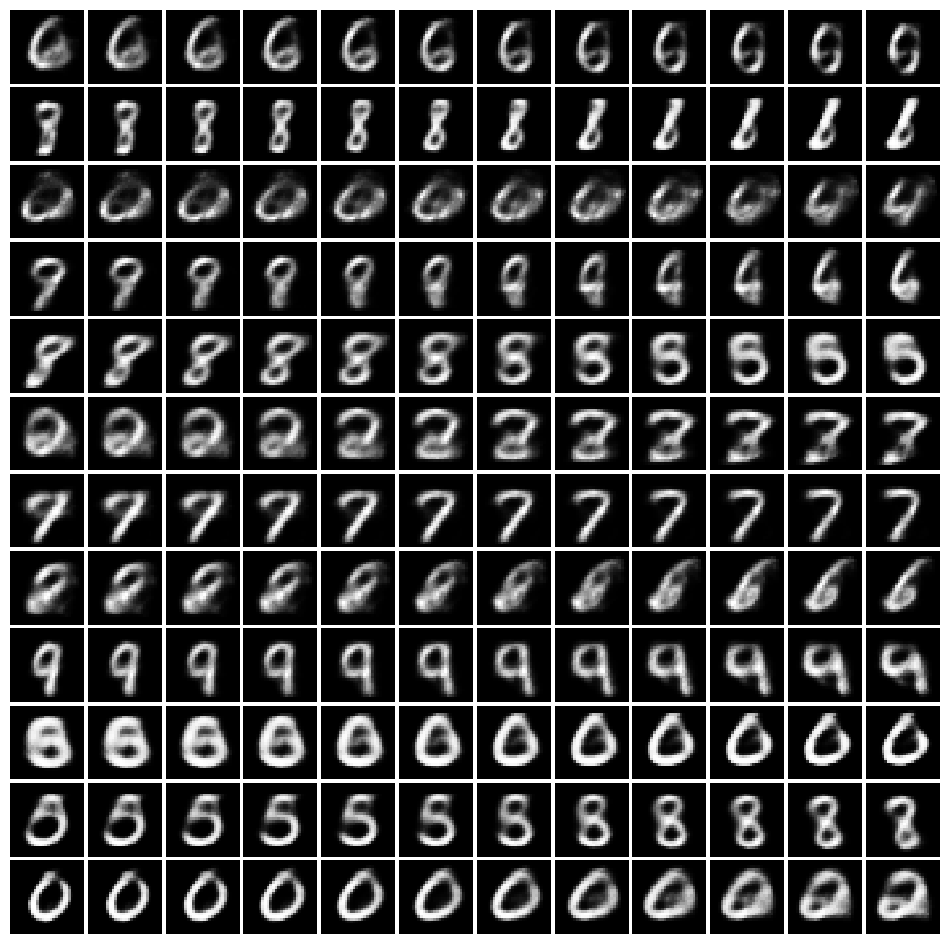

In [21]:
S = 12
latent_size = 15
device = 'cuda'
z0 = torch.randn(S,latent_size , device=device)
z1 = torch.randn(S, latent_size, device=device)
w = torch.linspace(0, 1, S, device=device).view(S, 1, 1)
z = (w * z0 + (1 - w) * z1).transpose(0, 1).reshape(S * S, latent_size)
x = vae_model.decoder(z)
show_images(x.data.cpu())

# Conditional FC-VAE 

The second model you'll develop will be very similar to the FC-VAE, but with a slight conditional twist to it. We'll use what we know about the labels of each MNIST image, and *condition* our latent space and image generation on the specific class. Instead of $q_{\phi} (z|x)$ and $p_{\phi}(x|z)$ we have $q_{\phi} (z|x,c)$  and $p_{\phi}(x|z, c)$

This will allow us to do some powerful conditional generation at inference time. We can specifically choose to generate more 1s, 2s, 9s, etc. instead of simply generating new digits randomly.

## Define Network with class input

Our CVAE architecture will be the same as our FC-VAE architecture, except we'll now add a one-hot label vector to both the x input (in our case, the flattened image dimensions) and the z latent space. 

If our one-hot vector is called `c`, then `c[label] = 1` and `c = 0` elsewhere.

For the `CVAE` class in `vae.py` use the same FC-VAE architecture implemented in the last network with the following modifications:

1. Modify the first linear layer of your `encoder` to take in not only the flattened input image, but also the one-hot label vector `c`
2. Modify the first layer of your `decoder` to project the latent space + one-hot vector to the `hidden_dim`
3. Lastly, implement the `forward` pass to combine the flattened input image with the one-hot vectors (`torch.cat`) before passing them to the `encoder` and combine the latent space with the one-hot vectors (`torch.cat`) before passing them to the `decoder`

## Train model

Using the same training script, let's now train our CVAE! 

Training for 10 epochs should take ~2 minutes and your loss should be less than 120.

In [27]:
from vae import CVAE
num_epochs = 10
latent_size = 15
from a6_helper import train_vae
input_size = 28*28
device = 'cuda'

cvae = CVAE(input_size, latent_size=latent_size)
cvae.cuda()
for epoch in range(0, num_epochs):
    train_vae(epoch, cvae, loader_train, cond=True)

Train Epoch: 0 	Loss: 166.517532
Train Epoch: 1 	Loss: 140.465256
Train Epoch: 2 	Loss: 131.355865
Train Epoch: 3 	Loss: 122.430153
Train Epoch: 4 	Loss: 124.473900
Train Epoch: 5 	Loss: 121.414642
Train Epoch: 6 	Loss: 119.616692
Train Epoch: 7 	Loss: 112.735870
Train Epoch: 8 	Loss: 116.076889
Train Epoch: 9 	Loss: 113.664299


## Visualize Results

We've trained our CVAE, now let's conditionally generate some new data! This time, we can specify the class we want to generate by adding our one hot matrix of class labels. We use `torch.eye` to create an identity matrix, which effectively gives us one label for each digit. When you run the cell below, you should get one example per digit. Each digit should be reasonably distinguishable (it is ok to run this cell a few times to save your best results).



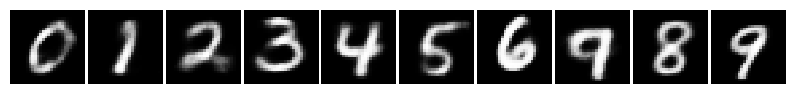

In [29]:
z = torch.randn(10, latent_size)
c = torch.eye(10, 10) # [one hot labels for 0-9]
import matplotlib.gridspec as gridspec
z = torch.cat((z,c), dim=-1).to(device='cuda')
cvae.eval()
samples = cvae.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(10, 1))
gspec = gridspec.GridSpec(1, 10)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    plt.savefig(os.path.join(GOOGLE_DRIVE_PATH,'conditional_vae_generation.jpg'))

## Final Check

Make sure all your training results (loss + images) are saved in the notebook. You can run "Runtime -> Restart and run all..." to double check before submitting